In [ ]:
import os
import gc
import re
import time
import random
import logging
import glob
import json
from pathlib import Path
import pathlib
from collections import defaultdict
from typing import Dict, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
import nibabel as nib
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [ ]:
# Base directory
base_dir = r'C:\liver-tumor-segmentation'

# Volume and segmentation directories
volume_dir = os.path.join(base_dir, 'volume')
segmentation_dir = os.path.join(base_dir, 'segmentations')

file_list = []

# Loop through volume files
for fname in os.listdir(volume_dir):
    if fname.endswith('.nii') or fname.endswith('.nii.gz'):
        case_id = fname.split('-')[-1].split('.')[0]
        vol_path = os.path.join(volume_dir, fname)

        # Try to find a matching segmentation file with .nii or .nii.gz
        found = False
        for ext in ['.nii', '.nii.gz']:
            seg_fname = f'segmentation-{case_id}{ext}'
            seg_path = os.path.join(segmentation_dir, seg_fname)
            if os.path.exists(seg_path):
                file_list.append({
                    'id': case_id,
                    'ct_path': vol_path,
                    'mask_path': seg_path
                })
                found = True
                break

        if not found:
            print(f"Warning: No segmentation file found for case {case_id}")

# Create dataframe
df_wide = pd.DataFrame(file_list)

# Preview result
df_wide = df_wide[['ct_path', 'mask_path']]
df_wide.head()

,ct_path,mask_path
0,C:\liver-tumor-segmentation\volume\volume-0.nii,C:\liver-tumor-segmentation\segmentations\segmentation-0.nii
1,C:\liver-tumor-segmentation\volume\volume-1.nii,C:\liver-tumor-segmentation\segmentations\segmentation-1.nii
2,C:\liver-tumor-segmentation\volume\volume-10.nii,C:\liver-tumor-segmentation\segmentations\segmentation-10.nii
3,C:\liver-tumor-segmentation\volume\volume-100.nii,C:\liver-tumor-segmentation\segmentations\segmentation-100.nii
4,C:\liver-tumor-segmentation\volume\volume-101.nii,C:\liver-tumor-segmentation\segmentations\segmentation-101.nii


In [ ]:
from tqdm import tqdm

# Directory for reduced masks
SAVE_DIR = r"C:\liver-tumor-segmentation\moeendon"
os.makedirs(SAVE_DIR, exist_ok=True)
BATCH_SIZE = 10
start_idx = 0
end_idx = len(df_wide)

for batch_start in range(start_idx, end_idx, BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, end_idx)
    batch_df = df_wide.iloc[batch_start:batch_end]

    print(f"\n🧩 Processing batch {batch_start} → {batch_end}")

    for i, row in tqdm(batch_df.iterrows(), total=len(batch_df)):
        mask_path = row["mask_path"]
        base = os.path.basename(mask_path).replace(".nii", "")
        save_path = os.path.join(SAVE_DIR, f"{base}_reduced.nii")

        # Skip if already reduced
        if os.path.exists(save_path):
            continue

        try:
            mask_nii = nib.load(mask_path)
            mask_data = mask_nii.get_fdata()

            # Keep only slices with liver/tumor
            keep_indices = [i for i in range(mask_data.shape[2]) if np.any(mask_data[:, :, i] > 0)]
            if not keep_indices:
                continue

            # Save reduced version
            reduced = mask_data[:, :, keep_indices]
            nib.save(nib.Nifti1Image(reduced, mask_nii.affine), save_path)

            del mask_data, reduced, mask_nii
            gc.collect()

        except Exception as e:
            print(f"⚠ Error processing {mask_path}: {e}")
            gc.collect()
            continue

    # Clear memory between batches
    gc.collect()

print("✅ All possible reduced masks saved.")


🧩 Processing batch 0 → 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.55s/it]



🧩 Processing batch 10 → 20


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]



🧩 Processing batch 20 → 30


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.40s/it]



🧩 Processing batch 30 → 40


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]



🧩 Processing batch 40 → 50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.34s/it]



🧩 Processing batch 50 → 60


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.01it/s]



🧩 Processing batch 60 → 70


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.01it/s]



🧩 Processing batch 70 → 80


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s]



🧩 Processing batch 80 → 90


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.14it/s]



🧩 Processing batch 90 → 100


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.02s/it]



🧩 Processing batch 100 → 110


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]



🧩 Processing batch 110 → 120


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]



🧩 Processing batch 120 → 130


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]



🧩 Processing batch 130 → 131


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]

✅ All possible reduced masks saved.


In [ ]:
reduced_dir = r"C:\liver-tumor-segmentation\moeendon"
reduced_files = [f for f in os.listdir(reduced_dir) if f.endswith("_reduced.nii")]
reduced_map = {f.replace("_reduced.nii", ""): os.path.join(reduced_dir, f) for f in reduced_files}

def get_reduced_path(mask_path):
    base = os.path.basename(mask_path).replace(".nii", "")
    return reduced_map.get(base, None)

df_wide["reduced_mask_path"] = df_wide["mask_path"].apply(get_reduced_path)

print("✅ Reduced mask paths mapped.")
print("Found:", df_wide['reduced_mask_path'].notnull().sum(), "reduced files.")

✅ Reduced mask paths mapped.
Found: 131 reduced files.


In [ ]:
# Just store slice indices instead of new .nii files
results = []

for idx, row in tqdm(df_wide.iterrows(), total=len(df_wide)):
    mask_path = row["mask_path"]
    base = os.path.basename(mask_path).replace(".nii", "")

    try:
        mask = nib.load(mask_path).get_fdata()

        # Find slices that contain non-background (liver or tumor)
        keep_indices = [i for i in range(mask.shape[2]) if np.any(mask[:, :, i] > 0)]

        # Skip empty ones
        if not keep_indices:
            continue

        results.append({
            "mask_path": mask_path,
            "ct_path": row["ct_path"],
            "kept_slices": keep_indices,
            "num_kept": len(keep_indices),
            "total_slices": mask.shape[2]
        })

        del mask
    except Exception as e:
        print(f"⚠ Error on {mask_path}: {e}")
        continue

df_indices = pd.DataFrame(results)
csv_path= r"C:\liver-tumor-segmentation\moeendon\valid_slices_metadata.csv"
df_indices.to_csv(csv_path, index=False)
print("✅ Saved slice indices metadata only — no large files created!")

100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [01:13<00:00,  1.79it/s]

✅ Saved slice indices metadata only — no large files created!


In [ ]:
REDUCED_CT_DIR = r"C:\liver-tumor-segmentation\moeendon\reduced_ct"
SUMMARY_PATH = r"C:\liver-tumor-segmentation\moeendon\reduced_ct_summary.csv"
os.makedirs(REDUCED_CT_DIR, exist_ok=True)

records = []

for i, row in tqdm(df_indices.iterrows(), total=len(df_indices)):
    ct_path = row['ct_path']
    mask_path = row['mask_path']

    # Parse kept_slices safely
    try:
        keep_indices = row['kept_slices']
        if not isinstance(keep_indices, list):
            keep_indices = eval(keep_indices)
    except Exception as e:
        print(f"⚠ Skipping invalid kept_slices for {ct_path}: {e}")
        continue

    base_id = os.path.basename(ct_path).replace(".nii", "")
    reduced_ct_path = os.path.join(REDUCED_CT_DIR, f"{base_id}_reduced.nii.gz")

    # Skip if already exists
    if os.path.exists(reduced_ct_path):
        records.append({
            "mask_path": mask_path,
            "ct_path": ct_path,
            "reduced_ct_path": reduced_ct_path,
            "num_kept": len(keep_indices)
        })
        continue

    try:
        ct_img = nib.load(ct_path)
        affine = ct_img.affine
        header = ct_img.header.copy()
        shape = ct_img.shape

        reduced_slices = []
        for idx in keep_indices:
            if 0 <= idx < shape[2]:
                slice_data = np.asanyarray(ct_img.dataobj[:, :, idx], dtype=np.float32)
                reduced_slices.append(slice_data)

        if len(reduced_slices) == 0:
            print(f"⚠ No valid slices kept for {ct_path}")
            continue

        reduced_ct = np.stack(reduced_slices, axis=-1)
        del reduced_slices
        gc.collect()

        reduced_img = nib.Nifti1Image(reduced_ct, affine, header)
        nib.save(reduced_img, reduced_ct_path)

        records.append({
            "mask_path": mask_path,
            "ct_path": ct_path,
            "reduced_ct_path": reduced_ct_path,
            "num_kept": len(keep_indices)
        })

        del ct_img, reduced_ct, reduced_img, affine, header
        gc.collect()

    except Exception as e:
        print(f"⚠ Error processing {ct_path}: {e}")
        gc.collect()
        continue

    if len(records) % 10 == 0:
        pd.DataFrame(records).to_csv(SUMMARY_PATH, index=False)
        gc.collect()

df_reduced_ct = pd.DataFrame(records)
df_reduced_ct.to_csv(SUMMARY_PATH, index=False)

print("✅ Reduced CT volumes saved successfully.")

if not df_reduced_ct.empty:
    df_indices = df_indices.merge(
        df_reduced_ct[['ct_path', 'reduced_ct_path']],
        on='ct_path', how='left'
    )
    csv_paths= r"/C:\liver-tumor-segmentation\moeendon\df_indices_with_reduced_ct.csv"
    df_indices.to_csv(csv_paths, index=False)
    print("✅ Added 'reduced_ct_path' column to df_indices.")
else:
    print("⚠ No reduced CT files were created. Check earlier errors.")

100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [07:43<00:00,  3.54s/it]


✅ Reduced CT volumes saved successfully.


OSError: Cannot save file into a non-existent directory: '\C:\liver-tumor-segmentation\moeendon'

In [ ]:
df_indices['reduced_mask_path']=df_wide['reduced_mask_path']
df_wide['reduced_ct_path']=df_indices['reduced_ct_path']
df_n=df_wide[['reduced_ct_path','reduced_mask_path']]
df_n.head()

,reduced_ct_path,reduced_mask_path
0,C:\liver-tumor-segmentation\moeendon\reduced_ct\volume-0_reduced.nii.gz,C:\liver-tumor-segmentation\moeendon\segmentation-0_reduced.nii
1,C:\liver-tumor-segmentation\moeendon\reduced_ct\volume-1_reduced.nii.gz,C:\liver-tumor-segmentation\moeendon\segmentation-1_reduced.nii
2,C:\liver-tumor-segmentation\moeendon\reduced_ct\volume-10_reduced.nii.gz,C:\liver-tumor-segmentation\moeendon\segmentation-10_reduced.nii
3,C:\liver-tumor-segmentation\moeendon\reduced_ct\volume-100_reduced.nii.gz,C:\liver-tumor-segmentation\moeendon\segmentation-100_reduced.nii
4,C:\liver-tumor-segmentation\moeendon\reduced_ct\volume-101_reduced.nii.gz,C:\liver-tumor-segmentation\moeendon\segmentation-101_reduced.nii


In [ ]:
sampl_path = df_n["reduced_ct_path"].iloc[0]  # or [1]
print("Sample path:", sampl_path)

# Load and inspect
img = nib.load(sampl_path)
mask_data = img.get_fdata()
print("Reduced ct shape:", mask_data.shape)
print("Mask unique values:", np.unique(mask_data))


Sample path: C:\liver-tumor-segmentation\moeendon\reduced_ct\volume-0_reduced.nii.gz
Reduced ct shape: (512, 512, 29)
Mask unique values: [-3023.99987793 -1024.0202041  -1022.97013929 ...  1255.99862666
  1264.00537078  1276.99992271]


In [ ]:
sampl_path = df_n["reduced_mask_path"].iloc[0]  # or [1]
print("Sample path:", sampl_path)

# Load and inspect
img = nib.load(sampl_path)
mask_data = img.get_fdata()
print("Reduced ct shape:", mask_data.shape)
print("Mask unique values:", np.unique(mask_data))


Sample path: C:\liver-tumor-segmentation\moeendon\segmentation-0_reduced.nii
Reduced ct shape: (512, 512, 29)
Mask unique values: [0. 1. 2.]


In [ ]:
IMG_SIZE = (256, 256)
WINDOW_CENTER = 60
WINDOW_WIDTH = 158  # For liver CT normalization
OUTPUT_DIR = r"C:\liver-tumor-segmentation\output"
os.makedirs(os.path.join(OUTPUT_DIR, "ct"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "mask"), exist_ok=True)

def load_nii_lazy(path):
    """Efficient memory-mapped loading of .nii file."""
    return nib.load(path).dataobj


def window_ct_image(img, center=WINDOW_CENTER, width=WINDOW_WIDTH):
    """Apply HU windowing for liver CT scans and normalize to [0,1]."""
    img_min = center - width // 2
    img_max = center + width // 2
    img = np.clip(img, img_min, img_max)
    img = (img - img_min) / (img_max - img_min + 1e-6)
    return img


def preprocess_ct_slice(slice_2d):
    """Resize and expand CT slice for CNN input."""
    slice_2d = np.rot90(slice_2d, k=1) 
    img = cv2.resize(slice_2d, IMG_SIZE, interpolation=cv2.INTER_LINEAR)
    img = np.expand_dims(img, axis=-1)  # (H, W, 1)
    return img.astype(np.float32)


def preprocess_mask_slice(mask_slice):
    """Resize and round mask to nearest label (0,1,2)."""
    mask_slice = np.rot90(mask_slice, k=1) 
    mask_slice = cv2.resize(mask_slice, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
    mask_slice = np.round(mask_slice).astype(np.uint8)
    return mask_slice


def preprocess_volume_pair(ct_path, mask_path, save_dir_ct, save_dir_mask):
    """Preprocess each CT–mask pair volume slice-by-slice."""
    ct_vol = load_nii_lazy(ct_path)
    mask_vol = load_nii_lazy(mask_path)
    patient_id = os.path.basename(ct_path).replace(".nii", "")

    saved_slices = 0
    for i in range(ct_vol.shape[2]):  # iterate all slices
        ct_slice = np.array(ct_vol[:, :, i])
        mask_slice = np.array(mask_vol[:, :, i])

        # Apply normalization and resizing
        ct_slice = window_ct_image(ct_slice)
        ct_slice = preprocess_ct_slice(ct_slice)
        mask_slice = preprocess_mask_slice(mask_slice)

        # Save processed slices
        ct_save_path = os.path.join(save_dir_ct, f"{patient_id}_slice{i:03d}.npy")
        mask_save_path = os.path.join(save_dir_mask, f"{patient_id}_slice{i:03d}_mask.npy")

        np.save(ct_save_path, ct_slice)
        np.save(mask_save_path, mask_slice)
        saved_slices += 1

    return saved_slices


def preprocess_all(df, save_root=OUTPUT_DIR):
    """Main preprocessing loop for all reduced CT/mask pairs."""
    stats = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        n_slices = preprocess_volume_pair(
            row["reduced_ct_path"],
            row["reduced_mask_path"],
            os.path.join(save_root, "ct"),
            os.path.join(save_root, "mask")
        )
        stats.append({
            "ct": row["reduced_ct_path"],
            "mask": row["reduced_mask_path"],
            "saved_slices": n_slices
        })

    df_stats = pd.DataFrame(stats)
    df_stats.to_csv(os.path.join(save_root, "preprocessing_summary.csv"), index=False)
    print("✅ Preprocessing complete! Total slices saved:", df_stats['saved_slices'].sum())


In [ ]:
preprocess_all(df_n)

100%|██████████████████████████████████████████████████████████████████████████████| 131/131 [1:35:46<00:00, 43.86s/it]

✅ Preprocessing complete! Total slices saved: 19163


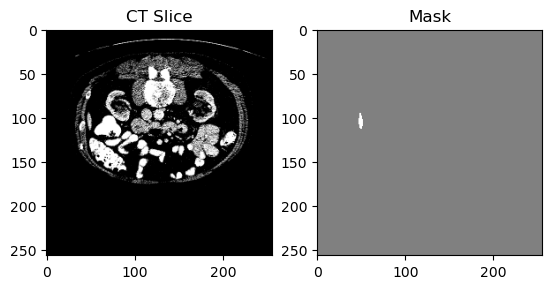

In [ ]:
p1=r"C:\liver-tumor-segmentation\output\ct\volume-103_reduced.gz_slice006.npy"
p2=r"C:\liver-tumor-segmentation\output\mask\volume-103_reduced.gz_slice006_mask.npy"
ct_sample = np.load(p1)
mask_sample = np.load(p2)

plt.subplot(1,2,1)
plt.imshow(ct_sample.squeeze(), cmap="gray")
plt.title("CT Slice")

plt.subplot(1,2,2)
plt.imshow(mask_sample, cmap="gray", alpha=0.5)
plt.title("Mask")
plt.show()

In [ ]:
p3 = r"C:\liver-tumor-segmentation\output\ct\*.npy"
p4 = r"C:\liver-tumor-segmentation\output\mask\*.npy"

ct_files = sorted(glob.glob(p3))
mask_files = sorted(glob.glob(p4))

print("CT files found:", len(ct_files))
print("Mask files found:", len(mask_files))

CT files found: 19163
Mask files found: 19163


In [ ]:
p3 = r"C:\liver-tumor-segmentation\output\ct\*.npy"
p4 = r"C:\liver-tumor-segmentation\output\mask\*.npy"
ct_files = sorted(glob.glob(p3))
mask_files = sorted(glob.glob(p4))
half=int(len(ct_files))
ct_files=ct_files[:half]
mask_files=mask_files[:half]

X_train, X_temp, y_train, y_temp = train_test_split(ct_files, mask_files, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(f"Total CT files: {len(ct_files)}")
print(f"Total Mask files: {len(mask_files)}")
print(len(X_train))

Total CT files: 19163
Total Mask files: 19163
13414


In [ ]:
print(len(X_test))

In [ ]:
# total_samples=19163
def analyze_class_distribution(mask_paths):
    total_samples = len(mask_paths)
    liver_only_count = 0
    liver_tumor_count = 0
    background_only_count = 0

    for mask_path in mask_paths:
        mask = np.load(mask_path)
        has_liver = np.any(mask == 1)
        has_tumor = np.any(mask == 2)

        if has_liver and has_tumor:
            liver_tumor_count += 1
        elif has_liver and not has_tumor:
            liver_only_count += 1
        elif not has_liver and not has_tumor:
            background_only_count += 1

    print(f"Total samples: {total_samples}")
    print(f"Liver only: {liver_only_count} ({liver_only_count/total_samples*100:.2f}%)")
    print(f"Liver + Tumor: {liver_tumor_count} ({liver_tumor_count/total_samples*100:.2f}%)")
    print(f"Background only: {background_only_count} ({background_only_count/total_samples*100:.2f}%)")
    
    return {
        "liver_only": liver_only_count,
        "liver_tumor": liver_tumor_count,
        "background_only": background_only_count
    }

# Example usage
p4 = r"C:\liver-tumor-segmentation\output\mask\*.npy"
mask_files = sorted(glob.glob(p4))
distribution = analyze_class_distribution(mask_files)

Total samples: 19163
Liver only: 12001 (62.63%)
Liver + Tumor: 7150 (37.31%)
Background only: 5 (0.03%)


In [ ]:
class BalancedDataset(Dataset):
    def __init__(self, ct_list, mask_list):
        self.ct_list = ct_list
        self.mask_list = mask_list
        self.tumor_indices = []
        self.non_tumor_indices = []
        for i, mask_path in enumerate(mask_list):
            mask = np.load(mask_path)
            if np.any(mask == 2):
                self.tumor_indices.append(i)
            else:
                self.non_tumor_indices.append(i)
        print(f"Tumor samples: {len(self.tumor_indices)}, Non-tumor samples: {len(self.non_tumor_indices)}")

    def __len__(self):
        return len(self.ct_list)

    def __getitem__(self, idx):
        ct = np.load(self.ct_list[idx])      
        mask = np.load(self.mask_list[idx])  
        # Normalize CT
        ct = (ct - np.min(ct)) / (np.max(ct) - np.min(ct) + 1e-6)
        if ct.ndim == 2:
            ct = np.expand_dims(ct, axis=0)
        elif ct.ndim == 3 and ct.shape[-1] == 1:
            ct = np.transpose(ct, (2, 0, 1))  
        ct = torch.tensor(ct, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long).squeeze()  # remove last dim if present
        return ct, mask


In [ ]:
dataset = BalancedDataset(ct_files, mask_files)
x, y = dataset[0]
print(x.shape, y.shape)

Tumor samples: 7157, Non-tumor samples: 12006
torch.Size([1, 256, 256]) torch.Size([256, 256])


In [ ]:
if torch.cuda.is_available():
    print("✅ CUDA is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current Device: {torch.cuda.current_device()}")
else:
    print("❌ CUDA is NOT available. Using CPU.")

✅ CUDA is available!
GPU Name: NVIDIA GeForce GTX 1650
Number of GPUs: 1
Current Device: 0


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, init_features=32):
        super().__init__()
        feats = init_features

        # Encoder
        self.enc1 = UNet._block(in_channels,    feats,       name="enc1")
        self.pool = nn.MaxPool2d(2,2)
        self.enc2 = UNet._block(feats,          feats*2,     name="enc2")
        
        self.enc3 = UNet._block(feats*2,        feats*4,     name="enc3")
        self.enc4 = UNet._block(feats*4,        feats*8,     name="enc4")

        # Bottleneck
        self.bottleneck = UNet._block(feats*8, feats*16,    name="bottleneck")

        # Decoder
        self.up4 = nn.ConvTranspose2d(feats*16, feats*8, 2,2)
        self.dec4 = UNet._block(feats*16,      feats*8,     name="dec4")
        self.up3 = nn.ConvTranspose2d(feats*8,  feats*4, 2,2)
        self.dec3 = UNet._block(feats*8,       feats*4,     name="dec3")
        self.up2 = nn.ConvTranspose2d(feats*4,  feats*2, 2,2)
        self.dec2 = UNet._block(feats*4,       feats*2,     name="dec2")
        self.up1 = nn.ConvTranspose2d(feats*2,  feats,   2,2)
        self.dec1 = UNet._block(feats*2,       feats,       name="dec1")

        self.conv = nn.Conv2d(feats, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder pass
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder pass + skip connections
        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        # raw logits → shape (B,3,H,W)
        return self.conv(d1)

    @staticmethod
    def _block(in_ch, features, name):
        return nn.Sequential(
            nn.Conv2d(in_ch,    features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
        )



In [ ]:
import numpy as np
import torch

def compute_class_weights(mask_list, n_classes=3):
    counts = np.zeros(n_classes)
    for path in mask_list:
        mask = np.load(path)
        for i in range(n_classes):
            counts[i] += np.sum(mask == i)
    freq = counts / np.sum(counts)
    weights = 1.0 / (freq + 1e-6)
    weights = weights / np.sum(weights)
    return torch.tensor(weights, dtype=torch.float32)


weights = compute_class_weights(mask_files)


In [ ]:
print(list(weights))

[tensor(0.0037), tensor(0.0524), tensor(0.9439)]


In [ ]:
train_ds = BalancedDataset(X_train, y_train)
val_ds = BalancedDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)


Tumor samples: 5052, Non-tumor samples: 8362
Tumor samples: 1025, Non-tumor samples: 1849


In [ ]:
test_ds = BalancedDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=True)

Tumor samples: 1080, Non-tumor samples: 1795


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = UNet(in_channels=1, out_channels=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

def compute_metrics(outputs, masks, num_classes=3):
    """
    Computes per-class and mean metrics for multiclass segmentation.
    outputs: (B, C, H, W)
    masks:   (B, H, W)
    """
    preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()  # (B, H, W)
    masks = masks.detach().cpu().numpy()

    dice_scores, precisions, recalls, accuracies = [], [], [], []

    for c in range(num_classes):
        pred_c = (preds == c)
        gt_c = (masks == c)

        tp = np.logical_and(pred_c, gt_c).sum()
        fp = np.logical_and(pred_c, np.logical_not(gt_c)).sum()
        fn = np.logical_and(np.logical_not(pred_c), gt_c).sum()
        tn = np.logical_and(np.logical_not(pred_c), np.logical_not(gt_c)).sum()

        precision = tp / (tp + fp + 1e-7)
        recall = tp / (tp + fn + 1e-7)
        dice = (2 * tp) / (2 * tp + fp + fn + 1e-7)
        accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-7)

        precisions.append(precision)
        recalls.append(recall)
        dice_scores.append(dice)
        accuracies.append(accuracy)

    return {
        "precision_per_class": precisions,
        "recall_per_class": recalls,
        "dice_per_class": dice_scores,
        "accuracy_per_class": accuracies,
        "mean_precision": np.mean(precisions),
        "mean_recall": np.mean(recalls),
        "mean_dice": np.mean(dice_scores),
        "mean_accuracy": np.mean(accuracies)
    }


class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_epoch(loader, model, criterion, optimizer, device, num_classes=3):
    model.train()
    running_loss = 0.0
    all_dice, all_prec, all_rec, all_acc = [], [], [], []

    for images, masks in tqdm(loader, desc="Training", leave=False):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute metrics
        metrics = compute_metrics(outputs, masks, num_classes=num_classes)
        all_dice.append(metrics["mean_dice"])
        all_prec.append(metrics["mean_precision"])
        all_rec.append(metrics["mean_recall"])
        all_acc.append(metrics["mean_accuracy"])

    return (
        running_loss / len(loader),
        np.mean(all_prec),
        np.mean(all_rec),
        np.mean(all_dice),
        np.mean(all_acc)
    )


def val_epoch(loader, model, criterion, device, num_classes=3):
    model.eval()
    running_loss = 0.0
    all_dice, all_prec, all_rec, all_acc = [], [], [], []

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            metrics = compute_metrics(outputs, masks, num_classes=num_classes)
            all_dice.append(metrics["mean_dice"])
            all_prec.append(metrics["mean_precision"])
            all_rec.append(metrics["mean_recall"])
            all_acc.append(metrics["mean_accuracy"])

    return (
        running_loss / len(loader),
        np.mean(all_prec),
        np.mean(all_rec),
        np.mean(all_dice),
        np.mean(all_acc)
    )


Using device: cuda


In [ ]:
num_epochs =19
best_val_loss = float('inf')
early_stopping = EarlyStopping(patience=3)

# To store metrics
history = {
    "train_loss": [], "val_loss": [],
    "train_prec": [], "val_prec": [],
    "train_rec": [], "val_rec": [],
    "train_dice": [], "val_dice": [],
    "train_acc": [], "val_acc": []
}

for epoch in range(num_epochs):
   
    train_loss, train_prec, train_rec, train_dice, train_acc = train_epoch(
        train_loader, model, criterion, optimizer, device, num_classes=3
    )

    val_loss, val_prec, val_rec, val_dice, val_acc = val_epoch(
        val_loader, model, criterion, device, num_classes=3
    )

    scheduler.step(val_loss)

    print(f"\n📘 Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train - Loss: {train_loss:.4f} | Dice: {train_dice:.3f} | Prec: {train_prec:.3f} | Rec: {train_rec:.3f} | Acc: {train_acc:.3f}")
    print(f"Val   - Loss: {val_loss:.4f} | Dice: {val_dice:.3f} | Prec: {val_prec:.3f} | Rec: {val_rec:.3f} | Acc: {val_acc:.3f}")

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_prec"].append(train_prec)
    history["val_prec"].append(val_prec)
    history["train_rec"].append(train_rec)
    history["val_rec"].append(val_rec)
    history["train_dice"].append(train_dice)
    history["val_dice"].append(val_dice)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # Save Best Model 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), r"C:\liver-tumor-segmentation\output\see_here\best_unetplusplus2.pth")
        print("✅ Saved Best Model")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("🛑 Early stopping triggered.")
        break


In [ ]:
#plot history
epochs = range(1, len(history["train_loss"]) + 1)
plt.figure(figsize=(12, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, history["train_loss"], label='Train Loss')
plt.plot(epochs, history["val_loss"], label='Val Loss')
plt.xlabel("epochs")
plt.ylabel("Magnitude")
plt.legend(); plt.title('Loss'); plt.grid(True)

# Dice
plt.subplot(2, 2, 2)
plt.plot(epochs, history["train_dice"], label='Train Dice')
plt.plot(epochs, history["val_dice"], label='Val Dice')
plt.xlabel("epochs")
plt.ylabel("Magnitude")
plt.legend(); plt.title('Dice Coefficient'); plt.grid(True)

# Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, history["train_prec"], label='Train Precision')
plt.plot(epochs, history["val_prec"], label='Val Precision')
plt.xlabel("epochs")
plt.ylabel("Magnitude")
plt.legend(); plt.title('Precision'); plt.grid(True)

# Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, history["train_acc"], label='Train Accuracy')
plt.plot(epochs, history["val_acc"], label='Val Accuracy')
plt.xlabel("epochs")
plt.ylabel("Magnitude")
plt.legend(); plt.title('Accuracy'); plt.grid(True)

# Recall
plt.plot(epochs, history["train_rec"], label='Train Recall')
plt.plot(epochs, history["val_rec"], label='Val Recall')
plt.legend(); plt.title('Recall'); plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F

# Load best trained model
model = UNet(in_channels=1, out_channels=3).to(device)
model.load_state_dict(torch.load(r"C:\liver-tumor-segmentation\output\see_here\best_unetplusplus.pth"))
model.eval()

def compute_metrics(outputs, masks):
    # outputs: (B, C, H, W)
    # masks:   (B, H, W)
    preds = torch.argmax(outputs, dim=1)
    preds = preds.contiguous().view(-1)
    masks = masks.contiguous().view(-1)

    intersection = torch.sum(preds * masks)
    union = torch.sum(preds) + torch.sum(masks)
    dice = (2. * intersection + 1e-7) / (union + 1e-7)

    tp = torch.sum((preds == 1) & (masks == 1)).item()
    fp = torch.sum((preds == 1) & (masks == 0)).item()
    fn = torch.sum((preds == 0) & (masks == 1)).item()
    tn = torch.sum((preds == 0) & (masks == 0)).item()

    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-7)

    return precision, recall, dice.item(), accuracy


# Evaluation loop
test_loss = 0.0
total_precision, total_recall, total_dice, total_accuracy = [], [], [], []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        loss = F.cross_entropy(outputs, masks)
        test_loss += loss.item()

        precision, recall, dice, accuracy = compute_metrics(outputs, masks)
        total_precision.append(precision)
        total_recall.append(recall)
        total_dice.append(dice)
        total_accuracy.append(accuracy)

# Mean metrics
test_loss /= len(test_loader)
mean_precision = np.mean(total_precision)
mean_recall = np.mean(total_recall)
mean_dice = np.mean(total_dice)
mean_accuracy = np.mean(total_accuracy)

print("\n✅ Test Results:")
print(f"Loss: {test_loss:.4f}")
print(f"Precision: {mean_precision:.4f}")
print(f"Recall: {mean_recall:.4f}")
print(f"Dice: {mean_dice:.4f}")
print(f"Accuracy: {mean_accuracy:.4f}")


In [ ]:
#Testing on test_ds
model.load_state_dict(torch.load(r'C:\liver-tumor-segmentation\output\see_here\best_unetplusplus2.pth'))
model.eval()

# Pick a validation sample
sample_ct, sample_mask = test_ds[986]
sample_ct = sample_ct.unsqueeze(0).to(device)  # Add batch dim
#print(len(test_ds))
with torch.no_grad():
    pred = model(sample_ct)
    pred = torch.argmax(pred, dim=1).cpu().numpy()[0]  # Get class map

# Visualize
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(sample_ct.cpu().numpy()[0, 0], cmap='gray')
axs[0].set_title('CT Slice')
axs[1].imshow(sample_mask.numpy(), cmap='jet')
axs[1].set_title('Ground Truth Mask')
axs[2].imshow(pred, cmap='jet')
axs[2].set_title('Predicted Mask')
plt.show()

In [ ]:
#Testing on test_ds
model.load_state_dict(torch.load(r'C:\liver-tumor-segmentation\output\see_here\best_unetplusplus2.pth'))
model.eval()

# Pick a validation sample
sample_ct, sample_mask = test_ds[469]
sample_ct = sample_ct.unsqueeze(0).to(device)  # Add batch dim
#print(len(test_ds))
with torch.no_grad():
    pred = model(sample_ct)
    pred = torch.argmax(pred, dim=1).cpu().numpy()[0]  # Get class map

# Visualize
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(sample_ct.cpu().numpy()[0, 0], cmap='gray')
axs[0].set_title('CT Slice')
axs[1].imshow(sample_mask.numpy(), cmap='jet')
axs[1].set_title('Ground Truth Mask')
axs[2].imshow(pred, cmap='jet')
axs[2].set_title('Predicted Mask')
plt.show()

In [ ]:
# When we have to check the model's prediction
import matplotlib.colors as mcolors
IMG_SIZE = (256, 256)
WINDOW_CENTER = 60
WINDOW_WIDTH = 158
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def window_ct_image(img, center=WINDOW_CENTER, width=WINDOW_WIDTH):
    img_min = center - width // 2
    img_max = center + width // 2
    img = np.clip(img, img_min, img_max)
    img = (img - img_min) / (img_max - img_min + 1e-6)
    return img

def preprocess_ct_slice(slice_2d):
    slice_2d = np.rot90(slice_2d, k=1)
    img = cv2.resize(slice_2d, IMG_SIZE, interpolation=cv2.INTER_LINEAR)
    img = np.expand_dims(img, axis=-1)
    return img.astype(np.float32)

def preprocess_mask_slice(mask_slice):
    mask_slice = np.rot90(mask_slice, k=1)
    mask_slice = cv2.resize(mask_slice, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
    mask_slice = np.round(mask_slice).astype(np.uint8)
    return mask_slice

# Load NIfTI files 
ct_path = r"C:\Users\anees\Downloads\liver_0.nii"
mask_path = r"C:\Users\anees\Downloads\liver_0_mask.nii"

ct_vol = nib.load(ct_path).get_fdata()
mask_vol = nib.load(mask_path).get_fdata()

print("CT shape:", ct_vol.shape)
print("Mask shape:", mask_vol.shape)

# Take slice number from user 
slice_no = int(input(f"Enter slice number (0–{ct_vol.shape[2]-1}): "))

ct_slice = np.array(ct_vol[:, :, slice_no])
mask_slice = np.array(mask_vol[:, :, slice_no])

ct_slice = window_ct_image(ct_slice)
ct_slice_resized = preprocess_ct_slice(ct_slice)
mask_slice_resized = preprocess_mask_slice(mask_slice)

input_tensor = torch.tensor(ct_slice_resized).permute(2,0,1).unsqueeze(0).to(DEVICE)

model = UNet(in_channels=1, out_channels=3).to(device)
model.load_state_dict(torch.load(r"C:\liver-tumor-segmentation\output\see_here\best_unetplusplus2.pth", map_location=DEVICE))
model.eval()

# --- Predict ---
with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1).cpu().numpy()[0]



colors = ["#1a0066",  # 0 = Background (dark purple-blue)
          "#66ff66",  # 1 = Liver (green)
          "#800000"]  # 2 = Tumor (dark maroon)

cmap_fixed = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm([0, 1, 2, 3], cmap_fixed.N)

# --- Display Results ---
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(ct_slice_resized.squeeze(), cmap='gray')
plt.title("CT Slice")

plt.subplot(1,3,2)
plt.imshow(mask_slice_resized, cmap=cmap_fixed, norm=norm)
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(pred, cmap=cmap_fixed, norm=norm)
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()



In [ ]:

IMG_SIZE = (256, 256)
WINDOW_CENTER = 60
WINDOW_WIDTH = 158
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def window_ct_image(img, center=WINDOW_CENTER, width=WINDOW_WIDTH):
    img_min = center - width // 2
    img_max = center + width // 2
    img = np.clip(img, img_min, img_max)
    img = (img - img_min) / (img_max - img_min + 1e-6)
    return img

def preprocess_ct_slice(slice_2d):
    slice_2d = np.rot90(slice_2d, k=1)
    img = cv2.resize(slice_2d, IMG_SIZE, interpolation=cv2.INTER_LINEAR)
    img = np.expand_dims(img, axis=-1)
    return img.astype(np.float32)

def preprocess_mask_slice(mask_slice):
    mask_slice = np.rot90(mask_slice, k=1)
    mask_slice = cv2.resize(mask_slice, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
    mask_slice = np.round(mask_slice).astype(np.uint8)
    return mask_slice

ct_path = r"C:\Users\anees\Downloads\liver_0.nii"
mask_path = r"C:\Users\anees\Downloads\liver_0_mask.nii"

ct_vol = nib.load(ct_path).get_fdata()
mask_vol = nib.load(mask_path).get_fdata()

print("CT shape:", ct_vol.shape)
print("Mask shape:", mask_vol.shape)

slice_no = int(input(f"Enter slice number (0–{ct_vol.shape[2]-1}): "))

ct_slice = np.array(ct_vol[:, :, slice_no])
mask_slice = np.array(mask_vol[:, :, slice_no])

ct_slice = window_ct_image(ct_slice)
ct_slice_resized = preprocess_ct_slice(ct_slice)
mask_slice_resized = preprocess_mask_slice(mask_slice)

input_tensor = torch.tensor(ct_slice_resized).permute(2,0,1).unsqueeze(0).to(DEVICE)

model = UNet(in_channels=1, out_channels=3).to(device)
model.load_state_dict(torch.load(r"C:\liver-tumor-segmentation\output\see_here\best_unetplusplus2.pth", map_location=DEVICE))
model.eval()

with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1).cpu().numpy()[0]

colors = ["#1a0066",  # 0 = Background (dark purple-blue)
          "#66ff66",  # 1 = Liver (green)
          "#800000"]  # 2 = Tumor (dark maroon)

cmap_fixed = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm([0, 1, 2, 3], cmap_fixed.N)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(ct_slice_resized.squeeze(), cmap='gray')
plt.title("CT Slice")

plt.subplot(1,3,2)
plt.imshow(mask_slice_resized, cmap=cmap_fixed, norm=norm)
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(pred, cmap=cmap_fixed, norm=norm)
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()



In [ ]:
# Path to directory containing all .nii mask files
mask_dir = r"C:\liver-tumor-segmentation\segmentations"

# Get all .nii files
mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.nii')]

severity_list = []
file_names = []

print("Analyzing severity across all mask volumes...\n")

for f in mask_files:
    path = os.path.join(mask_dir, f)
    mask_nii = nib.load(path)
    mask = mask_nii.get_fdata()

    # Round and convert to integer
    mask = np.round(mask).astype(int)

    # Count pixels
    liver_pixels = np.sum(mask == 1)
    tumor_pixels = np.sum(mask == 2)

    # Compute severity 
    severity = tumor_pixels / liver_pixels if liver_pixels > 0 else 0

    severity_list.append(severity)
    file_names.append(f)

    print(f"{f}: Liver={liver_pixels:,} | Tumor={tumor_pixels:,} | Severity={severity*100:.4f}%")

mean_sev = np.mean(severity_list)
min_sev = np.min(severity_list)
max_sev = np.max(severity_list)

print("\n============================")
print(f"📊 Total Volumes Analyzed: {len(severity_list)}")
print(f"Mean Severity: {mean_sev*100:.4f}%")
print(f"Min Severity:  {min_sev*100:.4f}%")
print(f"Max Severity:  {max_sev*100:.4f}%")
print("============================")

# plot histogram
plt.figure(figsize=(8,5))
plt.hist(np.array(severity_list)*100, bins=20, edgecolor='black')
plt.title("Severity Distribution Across Livers")
plt.xlabel("Severity (%) = (Tumor pixels / Liver pixels) × 100")
plt.ylabel("Number of Volumes")
plt.grid(alpha=0.4)
plt.show()


In [ ]:
sev_percent = np.array(severity_list) * 100

# Define bins (upper edges) and labels
bins = [0, 0.1, 0.2, 0.4, 0.6, 1, 2, 3, 4, 5, 7, 10 , 15 , 20, 30,40, 100]
labels = [
    "0–0.1%", "0.1–0.2%", "0.2–0.4%", "0.4–0.6%", "0.6–1%",
    "1–2%", "2–3%", "3–4%", "4–5%", "6-7%" , "7-10%" , "10-15%" , "15-20%","20-30%","30-40%",">40%"
]

# Categorize
categories = pd.cut(sev_percent, bins=bins, labels=labels, right=False)
distribution = categories.value_counts().sort_index()

# Print table
print("\n📊 Severity Distribution Table:")
print(distribution)

# Optional: bar chart
distribution.plot(kind='bar', figsize=(10,5), color='skyblue', edgecolor='black')
plt.title("Liver Tumor Severity Distribution")
plt.xlabel("Severity Range (%)")
plt.ylabel("Number of Volumes")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
mask_path = r"C:\liver-tumor-segmentation\segmentations\segmentation-13.nii"

# Load mask
mask_nii = nib.load(mask_path)
mask = mask_nii.get_fdata()

# Ensure integer rounding (avoid float mismatch)
mask = np.round(mask).astype(int)

# Count pixels
liver_pixels = np.sum(mask == 1)
tumor_pixels = np.sum(mask == 2)

# Compute severity
severity_ratio = tumor_pixels / liver_pixels if liver_pixels > 0 else 0

print(f"Total slices: {mask.shape[2]}")
print(f"Liver pixels: {liver_pixels:,}")
print(f"Tumor pixels: {tumor_pixels:,}")
print(f"Severity: {severity_ratio*100:.4f}%")


In [ ]:
def compute_tumor_severity(mask_path):
    """
    Calculates tumor severity from a NIfTI mask.
    Severity = (tumor_pixels / liver_pixels) * 100
    """
    # Load mask volume
    mask_vol = nib.load(mask_path).get_fdata().astype(np.uint8)
    
    # Count pixels
    tumor_pixels = np.sum(mask_vol == 2)
    liver_pixels = np.sum(mask_vol == 1)
    
    # Avoid division by zero
    if liver_pixels == 0:
        severity = 0
    else:
        severity = (tumor_pixels / liver_pixels) * 100

    print(f"🩸 Tumor pixels: {tumor_pixels:,}")
    print(f"🫀 Liver pixels: {liver_pixels:,}")
    print(f"⚖️ Severity Index: {severity:.2f}%")

    # Interpret severity level
    if severity == 0:
        level = "No tumor detected"
    elif severity < 5:
        level = "Mild"
    elif severity < 20:
        level = "Moderate"
    else:
        level = "Severe"
        
    print(f"📊 Severity Level: {level}")
    return severity, level

# Example usage:
mask_path = r"C:\Users\anees\Downloads\liver_0_mask.nii"
compute_tumor_severity(mask_path)